In [1]:

import os
import pickle
import numpy as np
import get_3dhst as hst
import elgtools as elg
import matplotlib.pyplot as plt
import jplus
import matplotlib.gridspec as gsc
from astropy.io import fits
import MockJPLUS as mtools

#mag_type = 'gpsfMags'
mag_type = 'gpsfMagsIso'
#j0660 = jplus.datasets.fetch_jplus_filter('J0660')
#wline = 3727.0 # OII rest-frame

#z_oii = elg.zline(wline, j0660.wave, j0660.throughput)
#print 'z-range',z_oii
z_oii = [0., 5]

hstdata = hst.select_3DHST_z(z_oii[0],z_oii[1])#,LineName='Ha_flux',LineMin=0.001)

deep2_data = '/home/CEFCA/aaorsi/work/elg_jplus/spec/deep2/dr4/zcat.deep2.dr4.fits'
deep2 = fits.open(deep2_data)[1].data


LoadJPLUS = True # Load a ELG catalogue of JPLUS already built

if LoadJPLUS:
    #gal_elgs = pickle.load(open(fout))
    elgfile = 'ELG_cand.data'
    #gfile = 'JPLUSxSDSSphotgal.data'
    gfile = 'JPLUS.data'
    gal_jplus = pickle.load(open(gfile))
    
else:
    mag_excess = "AND (m.MAG_APER_3_0[jplus::rSDSS]- m.MAG_APER_3_0[jplus::J0660]) > 0"
    gal_jplus = jplus.datasets.fetch_jplus_objects(mag_type=mag_type, overwrite=False, 
                                                 object_name="jplus_pz", nchunks=20, mag_limit=[16,24.],
                                                extra_where_conds='',db='idr', allphotoz=True, upperlimparams=True)
    
      
elgtiles = np.unique(gal_jplus['tile_id'])

jtiles = jplus.datasets.fetch_jplus_tile_list(db='dr1',overwrite=False)
meanAEGIS = [np.mean(hstdata['ra']), np.mean(hstdata['dec'])] # rough way to find a representative ra,dec of AEGIS

# tile closest to meanAEGIS:
# pick 4 closest tiles:
id_AEGIStile = np.argsort(elg.haversine_dist(meanAEGIS[0], meanAEGIS[1], jtiles['ra'], jtiles['dec']))
AEGIS_tile = jtiles['ref_tileID'][id_AEGIStile[0:4]]


    

j-plus [INFO]: Fetching J-PLUS Tile list
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/objects_tile_list_dr1_dual.h5


In [ ]:
print hstdata.keys()

In [ ]:

print AEGIS_tile, meanAEGIS


In [2]:
jplus_aegis = jplus.tools.select_object(gal_jplus, gal_jplus['tile_id'] == AEGIS_tile[0])
print jplus_aegis['J0660'][:,0]



#jplus_aegis = gal_elgs

[ 20.8050175  21.8190689  21.4838104 ...,  22.0985241  21.7230091
  21.6780777]


In [3]:
nhst = len(hstdata['ra'])
hst_coords = np.zeros([nhst,2])

for i in range(nhst):
    hst_coords[i,:] = [hstdata['ra'][i],hstdata['dec'][i]]

print hst_coords[0:10]
print hstdata['ra'][0:10]
hstdata['coords'] = hst_coords

[[ 214.9226532    52.8465004 ]
 [ 214.92126465   52.84579468]
 [ 214.92248535   52.84714127]
 [ 214.92086792   52.85242462]
 [ 214.91796875   52.84431076]
 [ 214.92793274   52.8518219 ]
 [ 214.9276886    52.85180664]
 [ 214.93209839   52.85494232]
 [ 214.92251587   52.84863281]
 [ 214.92729187   52.85163116]]
[ 214.9226532   214.92126465  214.92248535  214.92086792  214.91796875
  214.92793274  214.9276886   214.93209839  214.92251587  214.92729187]


In [4]:
d,ind = jplus.tools.crossmatch_angular(gal_jplus['coords'],hstdata['coords'],max_distance=3e-3)
m = ((d != np.inf))

jgal = jplus.tools.select_object(gal_jplus, m)
jgal['z_hst'] = hstdata['z'][ind[m]]



In [5]:
print len(jgal['tile_id'])

146


In [6]:
print len(gal_jplus['coords'][:,0])

2511633


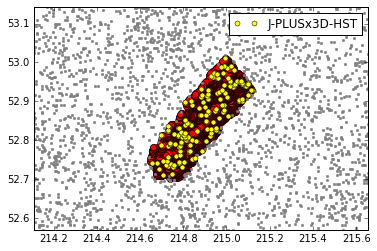

In [7]:
%matplotlib inline
plt.figure(2)

plt.plot(hstdata['coords'][:,0], hstdata['coords'][:,1],'o',color='red')
plt.plot(gal_jplus['coords'][:,0], gal_jplus['coords'][:,1],'.',color='grey',markersize=5)
plt.plot(jgal['coords'][:,0], jgal['coords'][:,1],'o',color='yellow',markersize=5, label='J-PLUSx3D-HST')
plt.xlim([hstdata['ra'].min()*.9975,hstdata['ra'].max()*1.0025])

plt.ylim([hstdata['dec'].min()*.9975,hstdata['dec'].max()*1.0025])          
plt.legend(loc='upper right')
#plt.title('3D-HST x J-PLUS')

1763


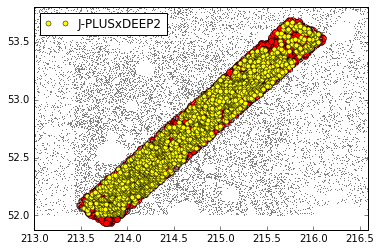

In [8]:
%matplotlib inline

d2mask = deep2['ZQUALITY'] > 2 # Select only Deep2 objects with good quality Redshifts

ndeep2 = len(deep2['RA'][d2mask])
dcoords = np.asarray([[deep2['RA'][d2mask][i], deep2['DEC'][d2mask][i]] for i in range(ndeep2)])
d,ind = jplus.tools.crossmatch_angular(gal_jplus['coords'],dcoords,max_distance=3e-3)
m = ((d != np.inf))

jdeep2 = jplus.tools.select_object(gal_jplus, m)
jdeep2['z_deep2'] = deep2['Z'][d2mask][ind[m]]

plt.figure(2)

print len(jdeep2['z_deep2'])

plt.plot(deep2['RA'][d2mask], deep2['DEC'][d2mask],'o',color='red')
plt.plot(gal_jplus['coords'][:,0], gal_jplus['coords'][:,1],',',color='gray',markersize=5)
plt.plot(jdeep2['coords'][:,0], jdeep2['coords'][:,1],'o',color='yellow',markersize=5, label='J-PLUSxDEEP2')
plt.xlim([jdeep2['coords'][:,0].min()*.9975,jdeep2['coords'][:,0].max()*1.0025])
plt.ylim([jdeep2['coords'][:,1].min()*.9975,jdeep2['coords'][:,1].max()*1.0025])          
plt.legend(loc='upper left')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gsc
from matplotlib.colors import LogNorm

def validate_photoz(samp, truez = 'zphoto', fig_name='photoz_val', 
                    rr = [0.01,0.99], cmap=plt.cm.coolwarm,
                   ylabel='True redshifts', rlim = [21, 20, 19], bins=40):

    plt.rcParams['figure.figsize'] = 15, 15
    fig = plt.figure(fig_name)

    gs = gsc.GridSpec(len(rlim),3)
    gs.update(wspace=0.0, hspace=0.0)

   
    pz_list = ['pz_leph', 'pz_tpz', 'pz_bpz']
    leg_list = ['LePhare', 'TPZ','BPZ']
    #rlim = [21, 20, 19]

    for j in range(len(rlim)):
        sel = samp['rJAVA'][:,0] < rlim[j]
        for i in range(3):
            ax = plt.subplot(gs[j,i])
            counts, ybins, xbins, image = ax.hist2d(samp[pz_list[i]][sel], samp[truez][sel], bins=bins, 
                                                 range=[rr, rr],cmap=cmap, normed=LogNorm(), 
                                                 cmin=0.01, label=leg_list[i], alpha=0.9)
            ax.plot(rr,rr,'k--')
            ax.set_xlabel(leg_list[i],fontsize=20)

            if i == 0:
                ax.set_ylabel(ylabel,fontsize=20)
                ax.text(0.15,0.75,r'$rJAVA < %.1f$'% rlim[j], fontsize=20,transform=ax.transAxes)
            else:
                ax.set_yticklabels([])

            if i == 2:
                ax.text(0.1,0.85,r'$N_{\rm gals}=%ld$'% len(samp[truez][sel]), fontsize=15,transform=ax.transAxes)

    return fig



In [ ]:
aff = validate_photoz(jdeep2, rlim=[23,22,21], ylabel='DEEP2', 
                      cmap=plt.cm.coolwarm, truez='z_deep2', bins=40, rr = [0,2.49])


In [ ]:
aff = validate_photoz(jgal, rlim=[23,22,21], ylabel='3D-HST', 
                      cmap=plt.cm.coolwarm, truez='z_hst', bins=40, rr = [0,3.49])


In [ ]:
print jdeep2['z_deep2'].max()

In [ ]:
%matplotlib inline
filternames = [ 'J0378','J0395', 'J0410','J0430','J0515', 'J0660',
               'J0861','uJAVA', 'gJAVA', 'rJAVA', 'iJAVA','zJAVA']
            #  'uSDSS', 'gSDSS', 'rSDSS', 'iSDSS', 'zSDSS']

sdss_fnames = ['uSDSS', 'gSDSS', 'rSDSS', 'iSDSS', 'zSDSS']

import matplotlib.gridspec as gsc
gs = gsc.GridSpec(13,13)
gs.update(wspace=0.025, hspace=0.025)

plt.rcParams['figure.figsize'] = 55, 55

nxm = len(jgal['tile_id'])
ix = 0
iy = 0
idg = 0

zsort = np.argsort(jgal['z_hst'])
for i0 in range(nxm):
    i = zsort[i0]
    ax= plt.subplot(gs[ix,iy])
    idg = ix + 13*iy
    for fname in filternames:
        filt = jplus.tools.fetch_jplus_filter(fname, quiet=True)
#        print np.median(filt.wave)
        ww = [filt.avgwave(), filt.avgwave()]
        ff = [jgal[fname][i,0], jgal[fname][i,0]]
   
        ax.plot(ww,ff,'o', color='blue', markersize=10)
        ax.errorbar(ww,ff,yerr= jgal[fname][i,1], color='blue')
        
        
        if fname == 'J0660' or fname == 'J0378' or fname == 'J0395' or fname=='J0861':
            fwidth = filt.rectwidth()
            ax.fill_between([ww[0] - fwidth/2.,ww[0] + fwidth/2.,ww[0] + fwidth/2.,ww[0] - fwidth/2.],
                        [15,15, 34, 34],facecolor='Grey',alpha=0.2)
       
    if sdss_fnames[0] in jgal: # If sdss bands exist
        for fname in sdss_fnames:
            filt = jplus.tools.fetch_sdss_filter(fname, quiet=True)
            ww = [filt[0,filt[1,:].argmax()],filt[0,filt[1,:].argmax()]]
            ff = [jgal[fname][i,0], jgal[fname][i,0]]
            ax.plot(ww,ff,'o', color='red', markersize=10)
            ax.errorbar(ww,ff,yerr= jgal[fname][i,1], color='red')
       
    ax.text(0.4,0.9,r'$z_{\rm HST}=%.2f$'%jgal['z_hst'][i], transform= ax.transAxes, fontsize=20)
    ax.text(0.1,0.1,'(%d)'%idg, transform=ax.transAxes,fontsize=15)
    ax.set_ylim([25.9, 20.99])
    ax.set_xlim([3000, 8999])
    if ix != 12:
        ax.set_xticklabels([])
    if iy >0:
        ax.set_yticklabels([])
    ix +=1
    if ix == 13:
        ix = 0
        iy += 1

plt.show()        


In [ ]:
%matplotlib inline
filternames = [ 'J0378','J0395', 'J0410','J0430','J0515', 'J0660',
               'J0861','uJAVA', 'gJAVA', 'rJAVA', 'iJAVA','zJAVA']
            #  'uSDSS', 'gSDSS', 'rSDSS', 'iSDSS', 'zSDSS']

sdss_fnames = ['uSDSS', 'gSDSS', 'rSDSS', 'iSDSS', 'zSDSS']
sdss_mw     = [3543, 4770, 6231, 7625, 9134]

import matplotlib.gridspec as gsc
gs = gsc.GridSpec(21,21)
gs.update(wspace=0.025, hspace=0.025)

plt.rcParams['figure.figsize'] = 60, 60

mask = ((jdeep2['z_deep2'] > 0.3) & (jdeep2['z_deep2'] < 0.4)) | (
    (jdeep2['z_deep2'] > 0.7) & (jdeep2['z_deep2'] < 0.8))

jd_elg = jplus.tools.select_object(jdeep2, mask)
nxm = len(jd_elg['tile_id'])
print 'Number of xmatched ELGs: %ld'%nxm
jd_elg['dm'] = mtools.gen_3fm(jd_elg['J0660'][:,0], jd_elg['rJAVA'][:,0], 
                          jd_elg['iJAVA'][:,0],Broad_NoLineName='iSDSS')

ix = 0
iy = 0
idg = 0

sortz = np.argsort(jd_elg['z_deep2'])

for i0 in range(nxm):
    i = sortz[i0]
    ax= plt.subplot(gs[ix,iy])
    idg = ix + 19*iy
    for fname in filternames:
        filt = jplus.tools.fetch_jplus_filter(fname, quiet=True)
#        print np.median(filt.wave)
        ww = [filt.avgwave(), filt.avgwave()]
        ff = [jd_elg[fname][i,0], jd_elg[fname][i,0]]
   
        ax.plot(ww,ff,'o', color='blue', markersize=10)
        ax.errorbar(ww,ff,yerr= jd_elg[fname][i,1], color='blue')
        
        
        if fname == 'J0660' or fname == 'J0378' or fname == 'J0395' or fname=='J0861':
            fwidth = filt.rectwidth()
            ax.fill_between([ww[0] - fwidth/2.,ww[0] + fwidth/2.,ww[0] + fwidth/2.,ww[0] - fwidth/2.],
                        [19,19, 24, 24],facecolor='Grey',alpha=0.2)
    fw = 0   
    if sdss_fnames[0] in jd_elg: # if sdss bands exist
        for fname in sdss_fnames:
            filt = jplus.tools.fetch_sdss_filter(fname, quiet=True)
#        ww = [filt[0,filt[1,:].argmax()],filt[0,filt[1,:].argmax()]]
            ww = [sdss_mw[fw], sdss_mw[fw]]
            fw += 1
            ff = [jd_elg[fname][i,0], jd_elg[fname][i,0]]
            ax.plot(ww,ff,'o', color='red', markersize=10)
            ax.errorbar(ww,ff,yerr= jd_elg[fname][i,1], color='red')

    ax.text(0.3,0.9,r'$z_{\rm DEEP2}=%.2f$'%jd_elg['z_deep2'][i], transform= ax.transAxes, fontsize=12)
    ax.text(0.3,0.8,r'$\Delta m=%.2f$'%jd_elg['dm'][i], transform= ax.transAxes, fontsize=12, color='red')
    ax.text(0.1,0.1,'(%d)'%idg, transform=ax.transAxes,fontsize=15)
    ax.set_ylim([24, 18.99])
    ax.set_xlim([3000, 8999])
    if ix != 20:
        ax.set_xticklabels([])
    if iy >0:
        ax.set_yticklabels([])
    ix +=1
    if ix == 21:
        ix = 0
        iy += 1

plt.show()        


In [ ]:

jd_elg['dm'] = mtools.gen_3fm(jd_elg['J0660'][:,0], jd_elg['rJAVA'][:,0], 
                          jd_elg['iJAVA'][:,0],Broad_NoLineName='iSDSS')

plt.rcParams['figure.figsize'] = 10, 10

plt.figure(6)
plt.rcParams['figure.figsize'] = 10, 10

lowz = (jd_elg['z_deep2'] < 0.4) & (jd_elg['dm'] > 0)
highz = (jd_elg['z_deep2'] > 0.6) & (jd_elg['dm'] > 0)

plt.hist(jd_elg['dm'][lowz], bins=20, color='red',alpha=0.5)
plt.hist(jd_elg['dm'][highz], bins=20, color='blue',alpha=0.5)

plt.show()

plt.figure(1)

u = jd_elg['uJAVA'][:,0]
g = jd_elg['gJAVA'][:,0]
r = jd_elg['rJAVA'][:,0]
i = jd_elg['iJAVA'][:,0]
z = jd_elg['zJAVA'][:,0]


plt.plot(g[lowz]-i[lowz], i[lowz]-z[lowz],'r.')
plt.plot(g[highz]-i[highz], i[highz]-z[highz],'b.')
plt.xlim([-5,5])


plt.figure(2)

plt.plot(jd_elg['pz_leph'], jd_elg['z_deep2'],'b.',label='LePhare')
plt.plot(jd_elg['pz_bpz'], jd_elg['z_deep2'],'r.',label='BPZ')
plt.plot(jd_elg['pz_tpz'], jd_elg['z_deep2'],'g.',label='TPZ')
plt.plot([0,1],[0,1,],'--')
plt.xlabel('photo-z')
plt.ylabel('z_deep2')
plt.legend()


In [ ]:
print filt.avgwave()
print filt.rectwidth()


In [ ]:
plt.figure('pz')

dz = (jd_elg['pz_bpz'] - jd_elg['z_deep2'])

plt.plot(jd_elg['dm'][highz], dz[highz],'b.',label='high-z')
plt.plot(jd_elg['dm'][lowz], dz[lowz],'r.',label='low-z')
plt.plot([-10,10],[0,0],'k--',linewidth=2)
plt.ylabel(r'$\Delta z$')
plt.xlabel(r'$m_{\rm Cont} - m_{J0660}$')
plt.xlim(-1,1)
plt.legend()
plt.show()




In [ ]:
%matplotlib inline
data_tiles = np.unique(gal_jplus['tile_id'])

gs = gsc.GridSpec(4,3)
gs.update(wspace=0.0, hspace=0.0)

filternames = [ 'J0378','J0395', 'J0410','J0430','J0515', 'J0660',
               'J0861','uJAVA', 'gJAVA', 'rJAVA', 'iJAVA','zJAVA']

idf = 0
for ix in range(4):
    for iy in range(3):

        ax = plt.subplot(gs[ix,iy])
        for tile in data_tiles:
            jp = jplus.tools.select_object(gal_jplus,gal_jplus['tile_id'] == tile)
            ax.plot(jp[filternames[idf]][:,0], 1/jp[filternames[idf]][:,1], ',',color = 'gray')

        jpa = jplus.tools.select_object(gal_jplus,gal_jplus['tile_id'] == AEGIS_tile)
        ax.plot(jpa[filternames[idf]][:,0], 1/jpa[filternames[idf]][:,1], '.',color = 'red', markersize= 10,
        label='AEGIS tile' if idf == 0 else '')
    
        
        ax.text(0.8,0.85,filternames[idf],transform=ax.transAxes,fontsize=10)
        ax.legend(loc='upper left',fontsize=10)
        ax.set_xlim([16.1,23.9])
        ax.set_ylim([0,99])
        if iy >0:
            ax.set_yticklabels([])
            
        idf += 1

        